In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# VGG16

In [5]:
import zipfile

In [6]:
# Chemin vers le fichier ZIP
zip_path = '/content/drive/MyDrive/Malaria Cell Images DataSet/archive.zip'
# Chemin vers le répertoire où extraire les fichiers
extract_path = '/content/Malaria_Cell_Images'

# Décompression
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, f1_score, classification_report,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score
)

In [8]:
# Détection de l'appareil (GPU si disponible, sinon CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Chemin d'accès aux images
image_root = '/content/Malaria_Cell_Images/cell_images'

Using device: cuda


In [14]:
import os
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from PIL import Image, UnidentifiedImageError

# Directories for the images
parasitized_dir = '/content/Malaria_Cell_Images/cell_images/Parasitized'
uninfected_dir = '/content/Malaria_Cell_Images/cell_images/Uninfected'

#infected_dir = '/content/Malaria_Cell_Images/cell_images/Parasitized'
#uninfected_dir = '/content/Malaria_Cell_Images/cell_images/Uninfected'

# Initialize lists to store images and labels
images = []
labels = []

# Helper function to check if a file is an image
def is_image_file(filename):
    try:
        img = Image.open(filename)
        img.verify()  # Verify that it is an actual image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

# Load Parasitized images
for filename in os.listdir(parasitized_dir):
    img_path = os.path.join(parasitized_dir, filename)
    if is_image_file(img_path):
        img = load_img(img_path, target_size=(50, 50))  # Resize if necessary
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(1)  # Label for parasitized

# Load Uninfected images
for filename in os.listdir(uninfected_dir):
    img_path = os.path.join(uninfected_dir, filename)
    if is_image_file(img_path):
        img = load_img(img_path, target_size=(50, 50))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(0)  # Label for uninfected

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (27558, 50, 50, 3)
Labels shape: (27558,)


In [10]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [16]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Charger le modèle VGG16 pré-entraîné, sans les couches supérieures
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Geler les couches du modèle VGG16
for layer in vgg.layers:
    layer.trainable = False

In [17]:
# Ajouter des couches de classification
x = Flatten()(vgg.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Créer le modèle
model = Model(inputs=vgg.input, outputs=x)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - AUC: 0.9163 - Precision: 0.8645 - Recall: 0.8527 - accuracy: 0.8606 - loss: 0.6634 - val_AUC: 0.9625 - val_Precision: 0.9253 - val_Recall: 0.8724 - val_accuracy: 0.8995 - val_loss: 0.2892
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - AUC: 0.9713 - Precision: 0.9224 - Recall: 0.9093 - accuracy: 0.9164 - loss: 0.2250 - val_AUC: 0.9683 - val_Precision: 0.9389 - val_Recall: 0.8738 - val_accuracy: 0.9071 - val_loss: 0.2441
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - AUC: 0.9752 - Precision: 0.9276 - Recall: 0.9134 - accuracy: 0.9215 - loss: 0.2014 - val_AUC: 0.9697 - val_Precision: 0.9247 - val_Recall: 0.8960 - val_accuracy: 0.9102 - val_loss: 0.2353
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 0.9814 - Precision: 0.9381 - Recall: 0.9255 - accuracy: 0.9328 - loss: 0.1726 - val_AUC: 0.9715 - val_Precision: 0.9031 - val_Recall: 0.9267 - val_accuracy: 0.9124 - val_loss: 0.2266
Epoch 5/10
689/689 ━━━━━

173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


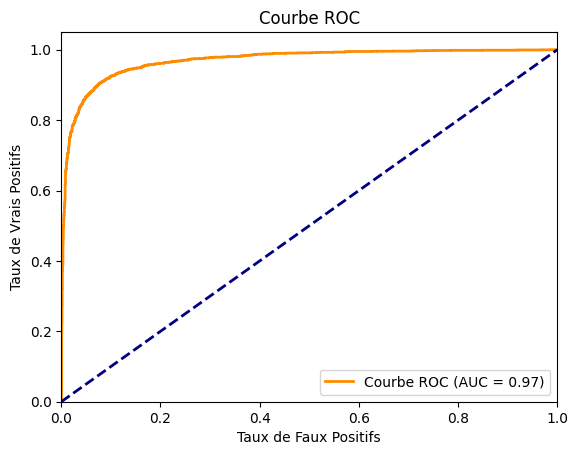

In [18]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul de la courbe ROC et AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

EffiscientNet

EffiscientNet B3

In [19]:
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [20]:
# Charger le modèle EfficientNetB0 pré-entraîné, sans les couches supérieures
efficient_net = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Geler les couches du modèle EfficientNet
for layer in efficient_net.layers:
    layer.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
# Ajouter des couches de classification
x = Flatten()(efficient_net.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Créer le modèle
model = Model(inputs=efficient_net.input, outputs=x)

# Compiler le modèle avec plusieurs métriques
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [22]:
# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 60s 42ms/step - AUC: 0.9301 - Precision: 0.8490 - Recall: 0.8580 - accuracy: 0.8554 - loss: 0.3306 - val_AUC: 0.9722 - val_Precision: 0.9628 - val_Recall: 0.8041 - val_accuracy: 0.8848 - val_loss: 0.2690
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - AUC: 0.9656 - Precision: 0.9008 - Recall: 0.8952 - accuracy: 0.8979 - loss: 0.2378 - val_AUC: 0.9723 - val_Precision: 0.9338 - val_Recall: 0.8731 - val_accuracy: 0.9042 - val_loss: 0.2333
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - AUC: 0.9695 - Precision: 0.9105 - Recall: 0.9108 - accuracy: 0.9107 - loss: 0.2232 - val_AUC: 0.9746 - val_Precision: 0.9608 - val_Recall: 0.8323 - val_accuracy: 0.8977 - val_loss: 0.2508
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - AUC: 0.9755 - Precision: 0.9190 - Recall: 0.9132 - accuracy: 0.9168 - loss: 0.1999 - val_AUC: 0.9766 - val_Precision: 0.9019 - val_Recall: 0.9339 - val_accuracy: 0.9149 - val_loss: 0.2040
Epoch 5/10
689/689 ━━━━━━━

173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step


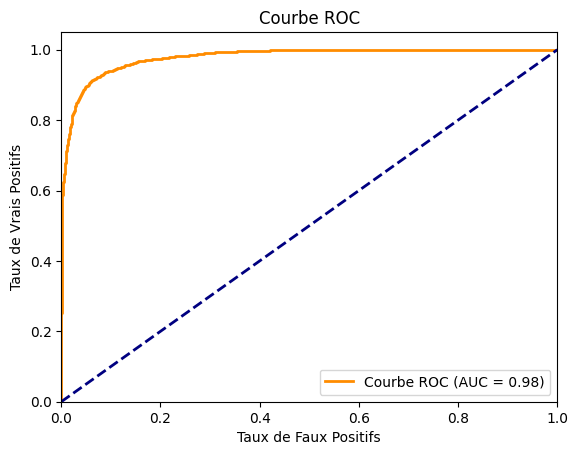

In [23]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul de la courbe ROC et AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()